# Satellite Image Classification - 7 Class Classifier
## An application of convolutional neural networks, transfer learning, and the field of explainable AI (XAI)
### Yene Irvine

PyTorch imports:

In [1]:
#IMPORTS
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import softmax
from torchvision.transforms.functional import to_pil_image, normalize
from torch.utils.data import Subset
from torchvision.transforms.functional import to_pil_image
from torchvision.models import vgg16, VGG16_Weights

All other imports:

In [2]:
import os
from PIL import Image
import wandb
from datetime import datetime
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

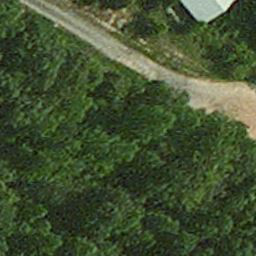

In [3]:
# Open en example TIFF file
image_path = 'YOUR-IMAGE-PATH'
image = Image.open(image_path)

# Display an image to ensure imports worked
display(image)

Linking WandB:

In [ ]:
wandb.login(key='YOUR-WANDB-KEY')
wandb.init(project='YOUR-WANDB-PROJECT', entity='YOUR-WANDB-ENTITY')

<pre style="font-size: 85%; font-family: monospace;">
wandb: Currently logged in as: yeneirvine. Use `wandb login --relogin` to force relogin

wandb: Tracking run with wandb version 0.16.3

wandb: <a href="https://wandb.ai/yeneirvine/645-Final-Project" target="_blank">⭐️ View project on WandB</a>

wandb: <a href="https://wandb.ai/yeneirvine/645-Final-Project/runs/fvigl5l0" target="_blank">🚀 View latest project run on WandB</a>
</pre>

<button onClick="this.nextSibling.style.display='block';this.style.display='none';">Display W&B run</button><iframe src='https://wandb.ai/yeneirvine/645-Final-Project/runs/fvigl5l0?jupyter=true' style='border:none;width:100%;height:420px;display:none;'></iframe>

Specifying directory for best model to test with:

In [5]:
model_save_dir = './model_checkpoints'
current_time = datetime.now().strftime('%Y%m%d-%H%M%S')
model_filename = f'best_model_{current_time}.pth'
model_save_path = os.path.join(model_save_dir, model_filename)

Setup the device (GPU or CPU) for training:

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Define transforms:

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for ImageNet
                         std=[0.229, 0.224, 0.225])
])

Create a custom dataset to handle TIF images, apply transforms, assign labels to images based on directory structure.
(The lowest level folder represents the class/label)

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_names = []

        # List only directories at the root level
        self.label_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        # Assign labels based on the order of label_names
        for label, subdir in enumerate(self.label_names):
            subdir_path = os.path.join(root_dir, subdir)
            
            # Get all images within this directory (including subdirectories)
            for dirname, _, filenames in os.walk(subdir_path):
                for filename in filenames:
                    if filename.lower().endswith('.tif'):
                        self.image_paths.append(os.path.join(dirname, filename))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert image to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


Initialize Dataset:

In [9]:
dataset_directory = '/path/to/satellite-dataset'
satellite_dataset = SatelliteDataset(root_dir=dataset_directory, transform=transform)
class_names = satellite_dataset.label_names  # Store class names in a global variable

Split up dataset:

In [10]:
# Calculate the sizes of each dataset part
total_size = len(satellite_dataset)
train_size = int(0.7 * total_size)  # 70% for training
validation_size = int(0.15 * total_size)  # 15% for validation
test_size = total_size - train_size - validation_size  # The remainder for testing
using_full_dataset = True

# Randomly split the dataset
train_dataset, validation_dataset, test_dataset = random_split(satellite_dataset, [train_size, validation_size, test_size])

#Test to ensure total_size is equal to the number of images in the total dataset
print(f"Total size: {total_size}")

Total size: 24747


Model Parameters:

In [12]:
epochs = 2
batch_size = 90
learning_rate = 1e-4
gamma = 0.8
num_classes=7
best_val_loss= float('inf')
patience = 2
early_stop_counter = 0

#Log to wandb:
wandb.config = {
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "num_classes": num_classes,
    "patience": patience
}

Dataloaders for each dataset:

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Model Definition:

In [14]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.to(device)  # Ensure the model is on the correct device
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss Function, Optimizer, and Learning Rate Scheduler definition
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  
lr_scheduler = ExponentialLR(optimizer, gamma=gamma)  

wandb.watch(model, log='all', log_freq=10)  # log='all' logs gradients and parameters

[]

# Training & Validation Loop:

In [15]:
import copy

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Convert images to tensors and apply any additional transforms as necessary
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item() * images.size(0)
        
        # Log batch loss to wandb
        if i % 10 == 0:
            wandb.log({"batch_train_loss": loss.item()})

    # Calculate and log the average loss for this epoch
    epoch_train_loss = running_loss / len(train_dataset)

    # epoch_loss = running_loss / len(train_dataset)
    # wandb.log({"epoch_train_loss": epoch_loss})

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in validation_loader:
            # Apply transforms here if necessary
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
    
    # Calculate and log the average validation loss for this epoch
    epoch_val_loss = val_running_loss / len(validation_dataset)

    wandb.log({
        "epoch_train_loss": epoch_train_loss,
        "epoch_val_loss": epoch_val_loss,
        "epoch": epoch
    })

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
        early_stop_counter = 0  # Reset counter
    else:
        early_stop_counter += 1  # Increment counter if no improvement

    
    # Early Stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break
    
    # Adjust the learning rate based on the scheduler
    lr_scheduler.step()

print('Finished Training')

# Load the best model weights
model.load_state_dict(best_model_wts)

# Ensure the model_save_dir exists
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save the best model
torch.save(model.state_dict(), model_save_path)

# Log final model and training details to wandb
wandb.log({"best_val_loss": best_val_loss})

Finished Training


Preparation for Testing Loop:

In [16]:
# Load the best model for testing
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode
test_loss = 0.0
test_corrects = torch.tensor(0, dtype=torch.long, device=device)

# Initialize dictionaries to track correct predictions and total samples for each class, to generate class-wise accuracies
num_classes = 7
class_correct = dict.fromkeys(range(num_classes), 0)
class_total = dict.fromkeys(range(num_classes), 0)

# Tracking predictions and true labels for confusion matrix
all_preds = torch.tensor([], dtype=torch.long, device=device)
all_labels = torch.tensor([], dtype=torch.long, device=device)

# Initializes an empty tensor for storing all probabilities
all_probabilities = torch.tensor([], dtype=torch.float, device=device)

# Test Loop:

In [17]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = softmax(outputs, dim=1)  # Apply softmax to obtain probabilities
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        
        # Concatenate predictions and labels for later confusion matrix and integrated gradient calculation
        all_probabilities = torch.cat((all_probabilities, probs), dim=0)
        all_preds = torch.cat((all_preds, preds))
        all_labels = torch.cat((all_labels, labels))

        # Update correct and total counts for each class
        for label, prediction in zip(labels, preds):
            if label == prediction:
                class_correct[label.item()] += 1
            class_total[label.item()] += 1

### Test Results, including class-specific accuracies:

In [18]:
# Calculate overall test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = test_corrects.double() / len(test_loader.dataset)

# Conversion to CPU required to use scikit-learn functions that operate on NumPy array
all_labels_np = all_labels.cpu().numpy()
all_preds_np = all_preds.cpu().numpy()

# Calculate overall precision and recall
precision = precision_score(all_labels_np, all_preds_np,  average='weighted', zero_division=0)
recall = recall_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)

# Calculate and log class-wise accuracy
class_accuracy = {cls: class_correct[cls] / class_total[cls] for cls in class_correct if class_total[cls] > 0}

# Log overall test loss, test accuracy, precision, recall, and class-wise accuracies
wandb.log({
    "test_loss": test_loss,  
    "test_accuracy": test_accuracy.item() if isinstance(test_accuracy, torch.Tensor) else test_accuracy,  # Ensure it's a Python scalar
    "precision": precision,
    "recall": recall
})
for cls, acc in class_accuracy.items():
    wandb.log({f'class_{cls}_accuracy': acc})

# Print overall and class-wise accuracies, as well as overall precision and recall
print(f'Overall Test Accuracy: {test_accuracy}, Overall Precision: {precision}, Overall Recall: {recall}')

for cls, acc in class_accuracy.items():
    if cls < len(class_names):
        class_name = class_names[cls]  # Safely fetch the class name using the index
        print(f'Class {class_name} Accuracy: {acc}')
    else:
        print(f'Class index {cls} out of range in class_names')

Overall Test Accuracy: 0.9940748720711016, Overall Precision: 0.9940899879708579, Overall Recall: 0.9940748720711016
Class transportation Accuracy: 0.9956989247311828
Class other objects Accuracy: 1.0
Class woodland Accuracy: 0.997920997920998
Class construction land Accuracy: 0.998272884283247
Class cultivated land Accuracy: 0.9862700228832952
Class other land Accuracy: 0.9918533604887984
Class water area Accuracy: 0.9887640449438202


## Confusion Matrix generation:

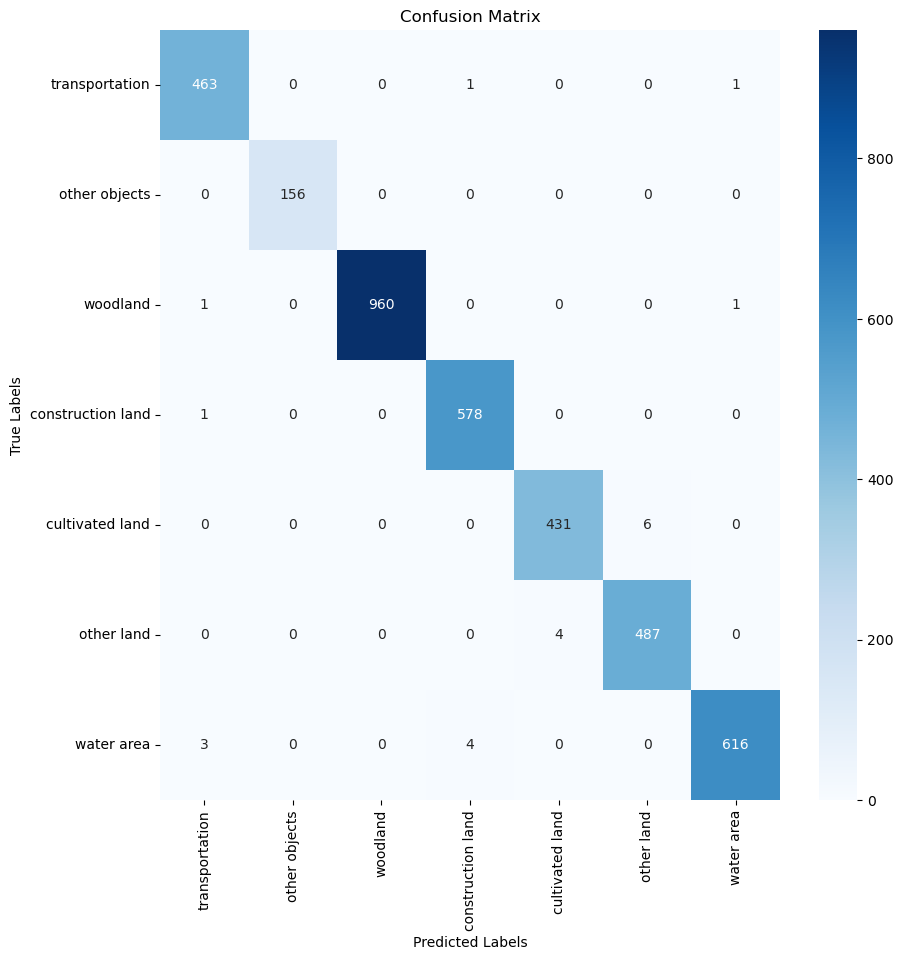

<Figure size 640x480 with 0 Axes>

In [19]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels.cpu(), all_preds.cpu())

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Incorporate the current time in the filename
conf_matrix_filename = f'confusion_matrix_{current_time}.png'
plt.savefig(conf_matrix_filename)

# Log the confusion matrix to wandb
wandb.log({"confusion_matrix": wandb.Image(conf_matrix_filename)})

## Integrated Gradients for visualization:

In [ ]:
import random
from torchvision.transforms.functional import to_pil_image

# Ensure the model is in evaluation mode
model.eval()

# Initialize the IntegratedGradients instance
integrated_gradients = IntegratedGradients(model)

# Function to visualize attributions
def visualize_attributions(image_tensor, attributions, pred_class, true_class):
    # Convert the attributions to a numpy array and normalize
    attributions = attributions.cpu().detach().numpy().squeeze()
    attributions = np.abs(attributions).mean(axis=0)
    attributions = attributions / np.max(attributions)
    
    # Un-normalize the image tensor for visualization purposes
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
    image_unnorm = to_pil_image((image_tensor * std + mean).squeeze())
    
    # Display the original image and attributions side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_unnorm)
    axs[0].axis('off')
    axs[0].set_title(f'Original Image: {true_class}')

    axs[1].imshow(attributions, cmap='hot')
    axs[1].axis('off')
    axs[1].set_title(f'Attributions: Predicted as {pred_class}')

    plt.show()

incorrect_prediction_found = False
selected_images = 0
while selected_images < 5 or not incorrect_prediction_found:
    index = random.randint(0, len(test_dataset) - 1)  # Random index in the range of the dataset
    image_tensor, label = test_dataset[index]  # Get the image and label
    true_class_name = class_names[label]  # Get the true class name using the label index

    # Generate predictions to use for Integrated Gradients
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    prediction = output.max(1, keepdim=True)[1]

    # Check if prediction is incorrect and mark it as found
    if not incorrect_prediction_found and prediction.item() != label:
        incorrect_prediction_found = True

    # Apply Integrated Gradients
    attributions = integrated_gradients.attribute(input_tensor, target=prediction.item(), n_steps=50)

    # Visualize the image with Integrated Gradients
    visualize_attributions(image_tensor, attributions, class_names[prediction.item()], true_class_name)
    
    selected_images += 1

![img 2](../gallery/2.png)
![incorrect image](../gallery/incorrect.png)
![img 3](../gallery/3.png)
![img 4](../gallery/4.png)
![img 5](../gallery/5.png)
![img 6](../gallery/6.png)
![img 7](../gallery/7.png)
![img 8](../gallery/8.png)
![img 9](../gallery/9.png)